In [1]:
import torch
import pandas as pd
from collections import Counter
import music21
from torch import nn
import numpy as np
from music21 import converter, instrument, note, chord, stream

In [2]:
torch.cuda.is_available()

True

# Load data and create the dataset

In [3]:
df = pd.read_csv(r'D:\Documents\Music generation project\data\df\ff_music_df.csv')
df = df.dropna()
df.head()

,id,music
0,1,4.9 E2 4.9 4.9 4.9 4.9 4.9 4.9 4.9 11.4 4.9 11...
1,2,C5 E4 C2 C5 E4 C2 G4 G4 C5 C5 D5 10.2 B-1 D5 1...
2,3,0.4 0.4 0.5 0.5 0.4 0.4 0.2 C5 0.2 F5 G5 0.4 0...
4,5,F3 C4 4.9 E4 C4 2.5 E4 C4 9.0 E4 C4 F3 C4 4.9 ...
5,6,C6 A3 E4 C6 F4 E4 C6 A3 E4 C6 F4 E4 E5 A3 E4 E...


BPTTIterator (one of the Pytorch Iterator for NLP) accept only one example as input, so we need to create a string that will contains all our music with every notes and chors. 

In [4]:
mylist = df['music'].to_list()
mylist = [' '.join(str(i) for i in mylist)]
len(mylist)

1

In [5]:
from torchtext.data import Field, BPTTIterator, Dataset, Example

#prepare the field

tokenize = lambda x: x.split()

TEXT = Field(sequential = True, tokenize = tokenize, fix_length = None)

datafields = [("text",TEXT)]

#loading the dataset

train_examples = [Example.fromlist(mylist, datafields)] 
train_data = Dataset(train_examples, datafields) #define a dataset composed of examples along with its field

#build the vocab

TEXT.build_vocab(train_data)

vocab = TEXT.vocab

#create the iterator object

train_iter = BPTTIterator(train_data, batch_size=10, bptt_len=5)

#if bptt_len = 3:

#E2 4.9 11.4 -> 4.9 11.4 D3



## Training 

In [6]:
class LSTMClassifier(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, dropout, embedding_dim, num_layers):
        super(LSTMClassifier, self).__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.emb = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers = num_layers, dropout = dropout)
        self.fc = nn.Linear(self.input_size, output_size)
    
    def forward(self, x):
        emb = self.emb(x)
        lstm_out, state = self.lstm(emb)
        logits = self.fc(lstm_out)
        return  logits, state
    
    def initHidden(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.input_size).cuda(),
                torch.zeros(self.num_layers, sequence_length, self.input_size).cuda())
        

In [7]:
def train(model, iterator, criterion, epoch):
    total_loss, total_correct, total_prediction = 0.0, 0.0, 0.0
    model.train()
    
    for epoch in range(epoch):
    
        for batch, x in enumerate(iterator): 
            optimizer.zero_grad()
            
            batch_text = x.text.cuda()
            batch_target = x.target.cuda()

            result, (state_h, state_c) = model(batch_text)
            loss = criterion(result.view(-1, result.shape[-1]), batch_target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            if batch % 100 == 0 :

                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })


In [8]:
from torch import optim

input_size = len(TEXT.vocab)
hidden_size = len(TEXT.vocab)
output_size= len(TEXT.vocab) #we want a probability for each note and chord
dropout = 0.4
embedding_dim = 128
num_layers = 3
epoch = 10

model = LSTMClassifier(input_size, hidden_size, output_size, dropout, embedding_dim, num_layers)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.cuda()
criterion.cuda()

train(model, train_iter, criterion, epoch)


{'epoch': 0, 'batch': 0, 'loss': 5.890377044677734}
{'epoch': 0, 'batch': 100, 'loss': 4.130503177642822}
{'epoch': 0, 'batch': 200, 'loss': 4.651741981506348}
{'epoch': 0, 'batch': 300, 'loss': 4.183234691619873}
{'epoch': 0, 'batch': 400, 'loss': 5.229642868041992}
{'epoch': 0, 'batch': 500, 'loss': 4.0528669357299805}
{'epoch': 0, 'batch': 600, 'loss': 4.214886665344238}
{'epoch': 0, 'batch': 700, 'loss': 3.9864771366119385}
{'epoch': 0, 'batch': 800, 'loss': 4.423928260803223}
{'epoch': 0, 'batch': 900, 'loss': 4.051108360290527}
{'epoch': 0, 'batch': 1000, 'loss': 4.103362560272217}
{'epoch': 0, 'batch': 1100, 'loss': 4.121941566467285}
{'epoch': 1, 'batch': 0, 'loss': 3.8193535804748535}
{'epoch': 1, 'batch': 100, 'loss': 3.626676559448242}
{'epoch': 1, 'batch': 200, 'loss': 4.129650592803955}
{'epoch': 1, 'batch': 300, 'loss': 3.9518303871154785}
{'epoch': 1, 'batch': 400, 'loss': 4.447238922119141}
{'epoch': 1, 'batch': 500, 'loss': 3.5935494899749756}
{'epoch': 1, 'batch': 600

# Generate music 

In [9]:
def predict(model, note, music_lenght):
    
    """ Generate a music given the note passed into the note 
    and lenght parameter """
    
    model.eval()
    
    words = note
    
    for i in range(music_lenght):
        x = torch.tensor([[TEXT.vocab.stoi[word_to_idx]] for word_to_idx in words]).cuda()
        result, (state_h, state_c) = model(x)
        last_word_logits = result[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p) #we could use argmax instead
        words.append(TEXT.vocab.itos[word_index])
    
    return words
        

With this model, we cannot predict the duration and the timing for each note/chord so we will put an offset (a distance) of 0.5 between each note.

In [14]:
pred = predict(model, ['E3'], music_lenght = 100)

offset = 0 
output_notes = []


for pattern in pred: #works (iterate on each note/chord one at the time)
        #pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.') #put every note(digit) of the chord in a list, each element is a note of the chord (ex: ['6','11'])
            notes = []
            for current_note in notes_in_chord: #take each note in the chord
                new_note = note.Note(int(current_note)) #transform the digit into the corresponding note format music21.note.Note 
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes) #creating a chord object with the previous new notes
            new_chord.offset = offset #indicating when the note should be play
            output_notes.append(new_chord) #append the new notes
        #pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        offset += 0.5

midi_stream = stream.Stream(output_notes)

Using music21, we can directly listen to our new generated song.

In [15]:
#read

midi_stream.show('midi')

We can also display the partition 

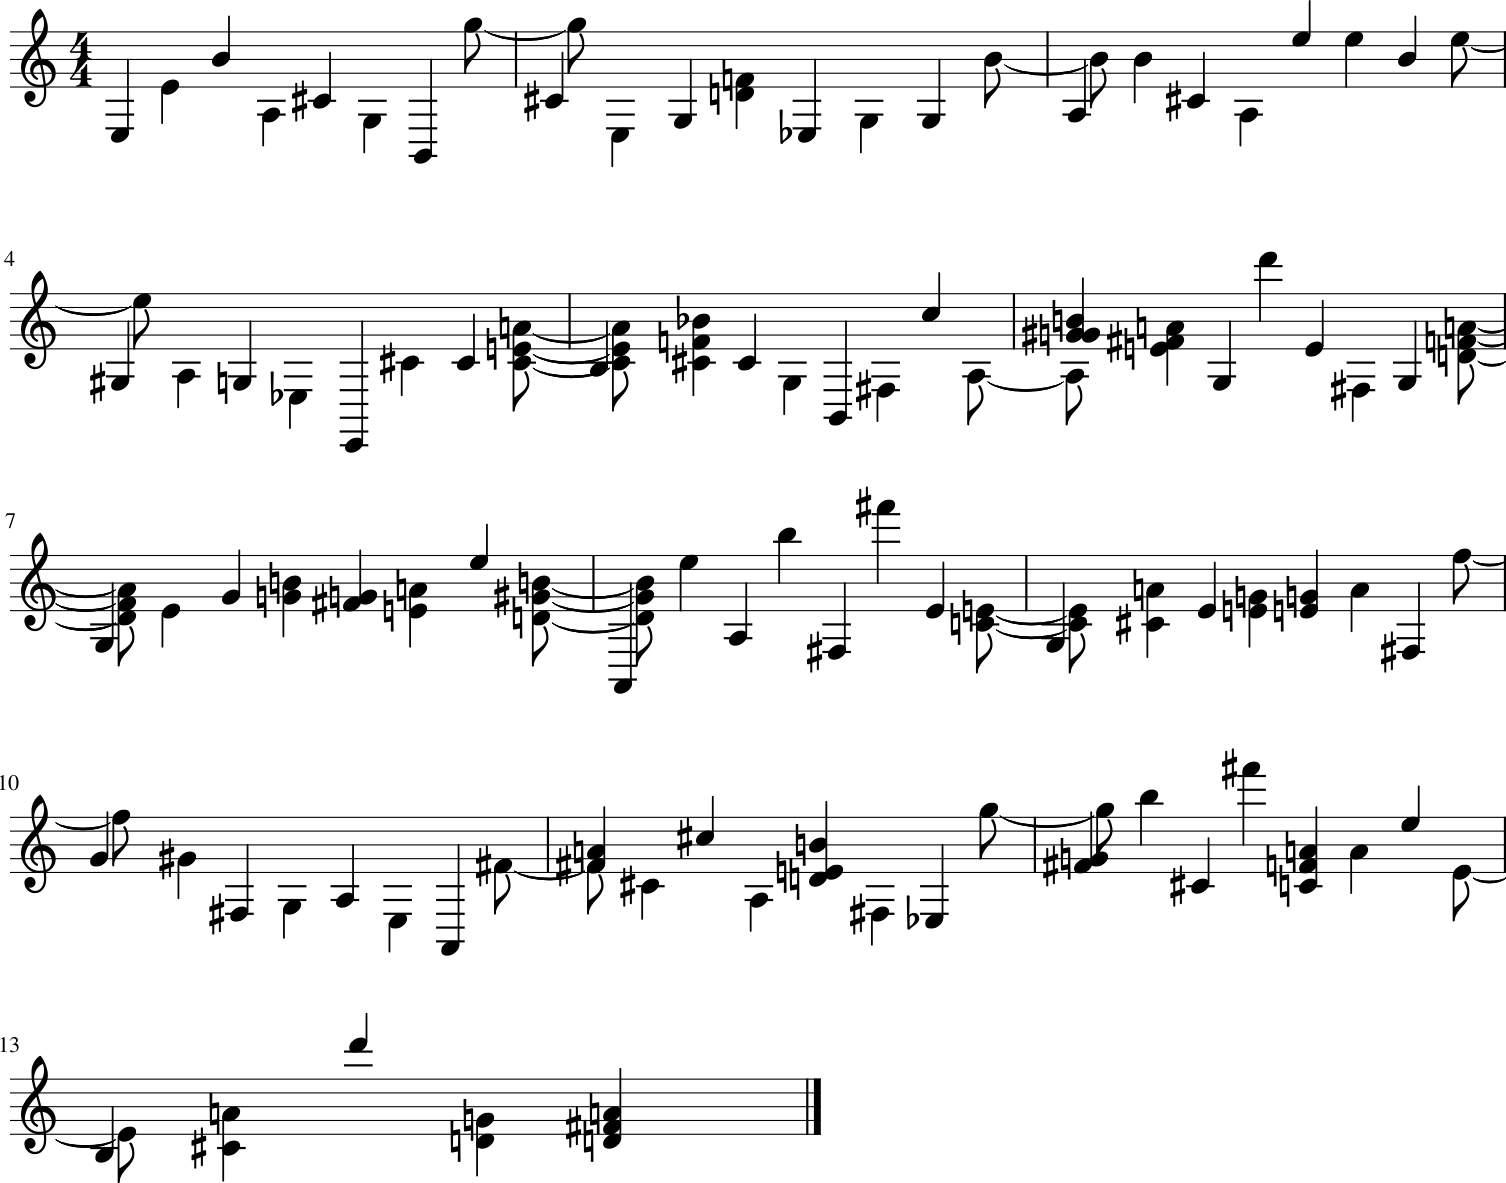

In [12]:
midi_stream.show()

Finally, we can also extract into a midi format.

In [16]:
midi_stream.write('midi', fp=r'D:\Documents\Music generation project\output\test_output4.mid')

'D:\\Documents\\Music generation project\\output\\test_output4.mid'